In [31]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing data
df = pd.read_csv("Combined_Emot_Data.csv")
df.head()

,unicode,emoji,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,...,Unicode block,le_+,le_-,le_0,sent_score,sent_score_class,upper_error_class,lower_error_class,sent_polar,primary_basic_emot
0,1F308,🌈,0.00,0.28,0.00,0.00,0.69,0.06,0.22,0.33,...,Miscellaneous Symbols and Pictographs,0.582418,0.065934,0.351648,0.516484,Positive,Positive,Positive,Positive,joy
1,1F319,🌙,0.00,0.31,0.00,0.00,0.25,0.00,0.06,0.25,...,Miscellaneous Symbols and Pictographs,0.655738,0.065574,0.278689,0.590164,Positive,Positive,Positive,Positive,anticipation
2,1F31A,🌚,0.06,0.08,0.17,0.06,0.42,0.19,0.06,0.11,...,Miscellaneous Symbols and Pictographs,0.622517,0.158940,0.218543,0.463576,Positive,Positive,Positive,Positive,joy
3,1F31E,🌞,0.00,0.22,0.00,0.00,0.78,0.00,0.11,0.22,...,Miscellaneous Symbols and Pictographs,0.581818,0.024242,0.393939,0.557576,Positive,Positive,Positive,Positive,joy
4,1F31F,🌟,0.00,0.28,0.00,0.00,0.53,0.00,0.25,0.31,...,Miscellaneous Symbols and Pictographs,0.386139,0.059406,0.554455,0.326733,Positive,Positive,Positive,Positive,joy


In [3]:
#List columns
df.columns

Index(['unicode', 'emoji', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'Position', 'Unicode block', 'le_+',
       'le_-', 'le_0', 'sent_score', 'sent_score_class', 'upper_error_class',
       'lower_error_class', 'sent_polar', 'primary_basic_emot'],
      dtype='object')

In [4]:
#Drop cols not needed for this work
df = df.drop(columns=['unicode', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'Position', 'Unicode block', 'sent_score_class', 'upper_error_class',
       'lower_error_class', 'sent_polar', 'primary_basic_emot'])
df.head()

,emoji,le_+,le_-,le_0,sent_score
0,🌈,0.582418,0.065934,0.351648,0.516484
1,🌙,0.655738,0.065574,0.278689,0.590164
2,🌚,0.622517,0.158940,0.218543,0.463576
3,🌞,0.581818,0.024242,0.393939,0.557576
4,🌟,0.386139,0.059406,0.554455,0.326733


In [5]:
#Import emoji lexicon

#Create lists for emojis and vectors
emoji_list = []
vector_list = []

#Extract contents into lists
with open('emoji2vec.txt', 'r', encoding='utf-8') as file:
    for idx, line in enumerate(file):
        if idx == 0:
            continue  # Skip the first line
        tokens = line.strip().split()
        emoji = tokens[0]
        vector = [float(v) for v in tokens[1:]]
        emoji_list.append(emoji)
        vector_list.append(vector)

#Confirm contents is all there
len(emoji_list), len(vector_list)

(1661, 1661)

In [6]:
#Convert list of emojis to a df
df_final_dim = pd.DataFrame(emoji_list, columns=['emoji'])
df_final_dim.head()

,emoji
0,🇸🇰
1,👔
2,🌀
3,🚾
4,👹


In [7]:
#Check shape
df_final_dim.shape

(1661, 1)

In [8]:
#Add in all true values from the human annotated dataset

#Create empty columns to store the data for each emotion
df_final_dim['le_+'] = np.nan
df_final_dim['le_-'] = np.nan
df_final_dim['le_0'] = np.nan
df_final_dim['sent_score'] = np.nan

df_final_dim.head()

,emoji,le_+,le_-,le_0,sent_score
0,🇸🇰,NaN,NaN,NaN,NaN
1,👔,NaN,NaN,NaN,NaN
2,🌀,NaN,NaN,NaN,NaN
3,🚾,NaN,NaN,NaN,NaN
4,👹,NaN,NaN,NaN,NaN


In [9]:
#Fill in values from the original df into the new df

#Define categories for classifications
classes = ['le_+', 'le_-', 'le_0', 'sent_score']

#Set emoji column as the index for both dfs
df.set_index('emoji', inplace=True)
df_final_dim.set_index('emoji', inplace=True)

#Populate data into the new df
df_final_dim.update(df[classes])

#Reset the index
df_final_dim.reset_index(inplace=True)
df.reset_index(inplace=True)

df_final_dim.isnull().sum()

emoji            0
le_+          1529
le_-          1529
le_0          1529
sent_score    1529
dtype: int64

In [10]:
#Importing df
df_basic = pd.read_csv("final_basic_emotions.csv")
df_basic.head()

,emoji,anger,joy,sadness,fear,surprise,disgust,anticipation,trust
0,👔,0.126262,0.143311,0.104819,0.116589,0.122332,0.107721,0.137325,0.141317
1,🌀,0.125151,0.127141,0.126822,0.137144,0.122332,0.082033,0.136325,0.142603
2,🚾,0.129196,0.140521,0.116989,0.122374,0.122332,0.115062,0.136324,0.129127
3,👹,0.114631,0.126279,0.153117,0.145137,0.122332,0.078083,0.137299,0.159623
4,🚻,0.112900,0.134558,0.123245,0.123930,0.122332,0.091016,0.137306,0.149267


In [12]:
#Create empty columns to store the data for each emotion
df_final_dim['anger'] = np.nan
df_final_dim['joy'] = np.nan
df_final_dim['sadness'] = np.nan
df_final_dim['fear'] = np.nan
df_final_dim['surprise'] = np.nan
df_final_dim['disgust'] = np.nan
df_final_dim['anticipation'] = np.nan
df_final_dim['trust'] = np.nan

df_final_dim.head()

,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust
emoji,,,,,,,,,,,,
🇸🇰,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
👔,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
🌀,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
🚾,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
👹,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#Add data into the dimensional theory df

#Create a list of basic emotions
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

#Set emoji column as the index for both dfs
#df_basic.set_index('emoji', inplace=True)
#df_final_dim.set_index('emoji', inplace=True)

#Populate data into the new df
df_final_dim.update(df_basic[emotions])

#Reset the index
df_final_dim.reset_index(inplace=True)
df_basic.reset_index(inplace=True)

df_final_dim.isnull().sum()

emoji              0
le_+            1529
le_-            1529
le_0            1529
sent_score      1529
anger              1
joy                1
sadness            1
fear               1
surprise           1
disgust            1
anticipation       1
trust              1
dtype: int64

In [17]:
#Visualise the data min, max, mean distributions
df_final_dim.describe()

,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust
count,132.000000,132.000000,132.000000,132.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000
mean,0.509553,0.190934,0.299513,0.318619,0.122087,0.137911,0.118356,0.119690,0.122378,0.100261,0.136967,0.140763
std,0.167632,0.170015,0.115376,0.317332,0.008426,0.012712,0.010683,0.007993,0.003601,0.013490,0.003825,0.010681
min,0.164835,0.008403,0.108037,-0.396501,0.092320,0.091324,0.084781,0.083941,0.095694,-0.023180,0.104046,0.099404
25%,0.360482,0.056537,0.220781,0.115110,0.117790,0.131688,0.112994,0.115207,0.122332,0.093483,0.137242,0.134871
50%,0.535984,0.123151,0.272018,0.416946,0.123082,0.137438,0.116838,0.119269,0.122332,0.100440,0.137283,0.140722
75%,0.634270,0.294019,0.326526,0.561786,0.126793,0.143553,0.121171,0.123117,0.122332,0.107426,0.137394,0.147027
max,0.798969,0.600583,0.734940,0.778351,0.194553,0.203568,0.197044,0.179909,0.168216,0.173729,0.173871,0.177931


In [19]:
#Scale the basic emotions as per previous method
df_final_dim['total_bt'] = df_final_dim['anger'] + df_final_dim['anticipation'] + df_final_dim['disgust'] + df_final_dim['fear'] + df_final_dim['joy'] + df_final_dim['sadness'] + df_final_dim['surprise'] + df_final_dim['trust']
df_final_dim['total_prescale_bt'] = df_final_dim['total_bt']

#Scale le+ and le- as per previous method
df_final_dim['total_dt'] = df_final_dim['le_+'] + df_final_dim['le_-']
df_final_dim['total_prescale_dt'] = df_final_dim['total_dt']

df_final_dim.head()

,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_prescale_bt,total_dt,total_prescale_dt
0,🇸🇰,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,👔,NaN,NaN,NaN,NaN,0.126262,0.143311,0.104819,0.116589,0.122332,0.107721,0.137325,0.141317,0.999676,0.999676,NaN,NaN
2,🌀,NaN,NaN,NaN,NaN,0.125151,0.127141,0.126822,0.137144,0.122332,0.082033,0.136325,0.142603,0.999552,0.999552,NaN,NaN
3,🚾,NaN,NaN,NaN,NaN,0.129196,0.140521,0.116989,0.122374,0.122332,0.115062,0.136324,0.129127,1.011926,1.011926,NaN,NaN
4,👹,NaN,NaN,NaN,NaN,0.114631,0.126279,0.153117,0.145137,0.122332,0.078083,0.137299,0.159623,1.036502,1.036502,NaN,NaN


In [20]:
#Remove the row that is totally empty
df_final_dim.dropna(subset=['anger'], inplace=True)
df_final_dim.head()

,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_prescale_bt,total_dt,total_prescale_dt
1,👔,NaN,NaN,NaN,NaN,0.126262,0.143311,0.104819,0.116589,0.122332,0.107721,0.137325,0.141317,0.999676,0.999676,NaN,NaN
2,🌀,NaN,NaN,NaN,NaN,0.125151,0.127141,0.126822,0.137144,0.122332,0.082033,0.136325,0.142603,0.999552,0.999552,NaN,NaN
3,🚾,NaN,NaN,NaN,NaN,0.129196,0.140521,0.116989,0.122374,0.122332,0.115062,0.136324,0.129127,1.011926,1.011926,NaN,NaN
4,👹,NaN,NaN,NaN,NaN,0.114631,0.126279,0.153117,0.145137,0.122332,0.078083,0.137299,0.159623,1.036502,1.036502,NaN,NaN
5,🚻,NaN,NaN,NaN,NaN,0.112900,0.134558,0.123245,0.123930,0.122332,0.091016,0.137306,0.149267,0.994555,0.994555,NaN,NaN


In [23]:
#Scale primary categories as per previous method

scale_cols=['total_bt', 'total_dt', 'sent_score', 'le_0']

#Apply min max scaler to relevant columns
def scaling():
    scaler = MinMaxScaler(feature_range=(0.01, 1)) #To avoid re-addition of zero-probabilities
    df_final_dim[scale_cols]=scaler.fit_transform(df_final_dim[scale_cols])
    return df_final_dim

#Apply the function
df_final_dim = scaling()

#Verify it worked
df_final_dim.describe()

,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_prescale_bt,total_dt,total_prescale_dt
count,132.000000,132.000000,132.000000,132.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,132.000000,132.000000
mean,0.509553,0.190934,0.312378,0.612603,0.122087,0.137911,0.118356,0.119690,0.122378,0.100261,0.136967,0.140763,0.585436,0.998411,0.697622,0.700487
std,0.167632,0.170015,0.182201,0.267403,0.008426,0.012712,0.010683,0.007993,0.003601,0.013490,0.003825,0.010681,0.055065,0.015700,0.182201,0.115376
min,0.164835,0.008403,0.010000,0.010000,0.092320,0.091324,0.084781,0.083941,0.095694,-0.023180,0.104046,0.099404,0.010000,0.834339,0.010000,0.265060
25%,0.360482,0.056537,0.188045,0.441114,0.117790,0.131688,0.112994,0.115207,0.122332,0.093483,0.137242,0.134871,0.556637,0.990200,0.654964,0.673474
50%,0.535984,0.123151,0.268958,0.695459,0.123082,0.137438,0.116838,0.119269,0.122332,0.100440,0.137283,0.140722,0.590159,0.999758,0.741042,0.727982
75%,0.634270,0.294019,0.355036,0.817510,0.126793,0.143553,0.121171,0.123117,0.122332,0.107426,0.137394,0.147027,0.614546,1.006711,0.821955,0.779219
max,0.798969,0.600583,1.000000,1.000000,0.194553,0.203568,0.197044,0.179909,0.168216,0.173729,0.173871,0.177931,1.000000,1.116614,1.000000,0.891963


In [25]:
#Scale subclassifiers within categories-basic emotions

#Determine scaling factor for the row
df_final_dim['scaling_factor'] = df_final_dim['total_prescale_bt'] / df_final_dim['total_bt']

#Scale each basic emotion value using the scaling factor
df_final_dim['anger'] = df_final_dim['anger'] / df_final_dim['scaling_factor']
df_final_dim['anticipation'] = df_final_dim['anticipation'] / df_final_dim['scaling_factor']
df_final_dim['disgust'] = df_final_dim['disgust'] / df_final_dim['scaling_factor']
df_final_dim['fear'] = df_final_dim['fear'] / df_final_dim['scaling_factor']
df_final_dim['joy'] = df_final_dim['joy'] / df_final_dim['scaling_factor']
df_final_dim['sadness'] = df_final_dim['sadness'] / df_final_dim['scaling_factor']
df_final_dim['surprise'] = df_final_dim['surprise'] / df_final_dim['scaling_factor']
df_final_dim['trust'] = df_final_dim['trust'] / df_final_dim['scaling_factor']

#Remove columns that are no longer needed
df_final_dim = df_final_dim.drop(columns=['total_prescale_bt', 'scaling_factor'])

df_final_dim.describe()

,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_dt,total_prescale_dt
count,132.000000,132.000000,132.000000,132.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,132.000000,132.000000
mean,0.509553,0.190934,0.312378,0.612603,0.071392,0.080940,0.069454,0.070164,0.071669,0.059040,0.080211,0.082566,0.585436,0.697622,0.700487
std,0.167632,0.170015,0.182201,0.267403,0.006620,0.011041,0.009726,0.008030,0.006087,0.010398,0.006767,0.010202,0.055065,0.182201,0.115376
min,0.164835,0.008403,0.010000,0.010000,0.002092,0.001128,0.001269,0.001292,0.001466,-0.000278,0.001650,0.001381,0.010000,0.010000,0.265060
25%,0.360482,0.056537,0.188045,0.441114,0.067537,0.074921,0.064242,0.065743,0.068252,0.052919,0.076511,0.076540,0.556637,0.654964,0.673474
50%,0.535984,0.123151,0.268958,0.695459,0.071736,0.080554,0.068364,0.069729,0.071683,0.059227,0.080328,0.082389,0.590159,0.741042,0.727982
75%,0.634270,0.294019,0.355036,0.817510,0.075181,0.087342,0.072863,0.073918,0.075166,0.065307,0.084187,0.088546,0.614546,0.821955,0.779219
max,0.798969,0.600583,1.000000,1.000000,0.114982,0.143305,0.173443,0.139684,0.109557,0.102675,0.122995,0.157142,1.000000,1.000000,0.891963


In [26]:
#Repeat for dimensional theory subclassifiers

#Determine scaling factor for the row
df_final_dim['scaling_factor'] = df_final_dim['total_prescale_dt'] / df_final_dim['total_dt']

#Scale each basic emotion value using the scaling factor
df_final_dim['le_+'] = df_final_dim['le_+']/df_final_dim['scaling_factor']

#Remove columns that are no longer needed
df_final_dim = df_final_dim.drop(columns=['total_prescale_dt', 'scaling_factor'])

#Verify transformations are ok
df_final_dim.describe()

,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_dt
count,132.000000,132.000000,132.000000,132.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,132.000000
mean,0.504398,0.190934,0.312378,0.612603,0.071392,0.080940,0.069454,0.070164,0.071669,0.059040,0.080211,0.082566,0.585436,0.697622
std,0.195644,0.170015,0.182201,0.267403,0.006620,0.011041,0.009726,0.008030,0.006087,0.010398,0.006767,0.010202,0.055065,0.182201
min,0.008333,0.008403,0.010000,0.010000,0.002092,0.001128,0.001269,0.001292,0.001466,-0.000278,0.001650,0.001381,0.010000,0.010000
25%,0.352980,0.056537,0.188045,0.441114,0.067537,0.074921,0.064242,0.065743,0.068252,0.052919,0.076511,0.076540,0.556637,0.654964
50%,0.507432,0.123151,0.268958,0.695459,0.071736,0.080554,0.068364,0.069729,0.071683,0.059227,0.080328,0.082389,0.590159,0.741042
75%,0.658001,0.294019,0.355036,0.817510,0.075181,0.087342,0.072863,0.073918,0.075166,0.065307,0.084187,0.088546,0.614546,0.821955
max,0.863423,0.600583,1.000000,1.000000,0.114982,0.143305,0.173443,0.139684,0.109557,0.102675,0.122995,0.157142,1.000000,1.000000


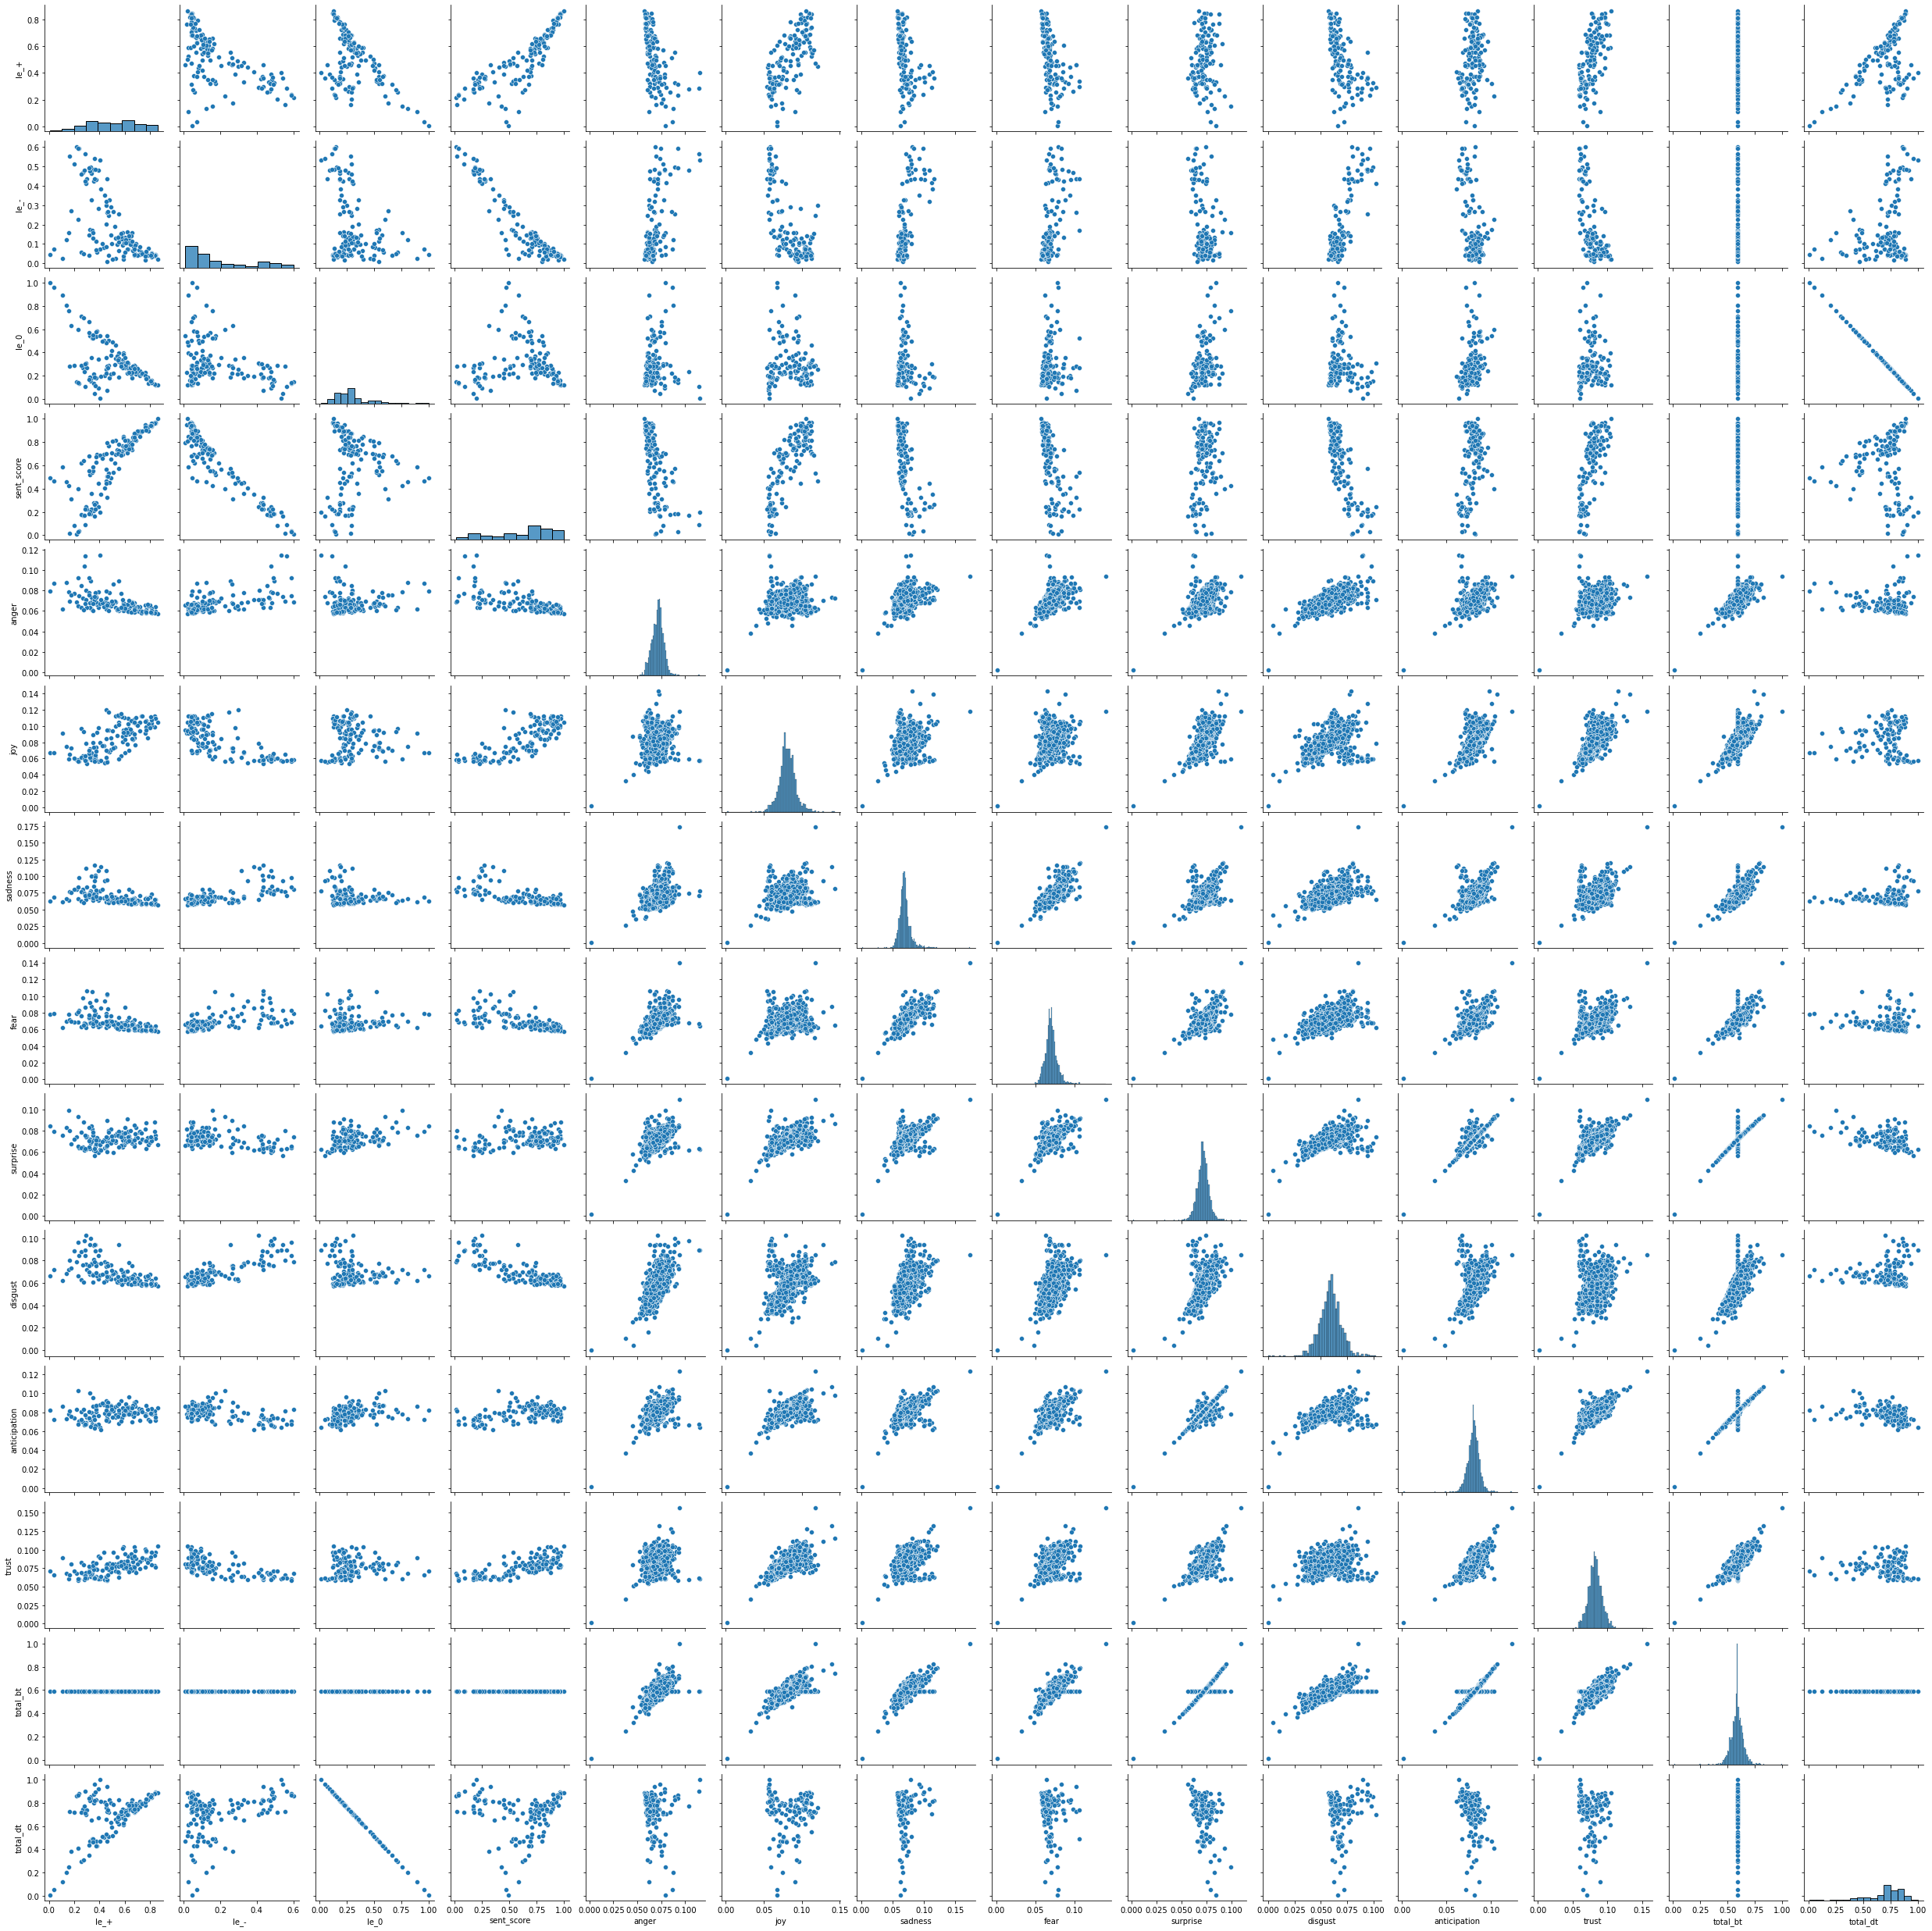

In [27]:
#Create a pairplot
sns.pairplot(df_final_dim)

# Predicting le_+ univariate

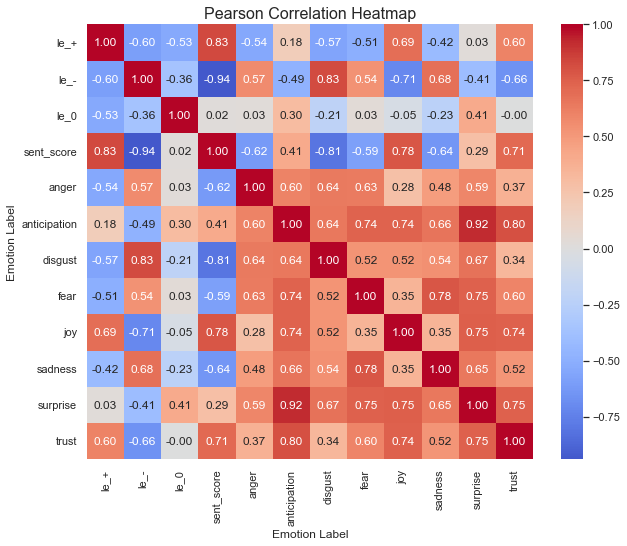

In [62]:
#Create a pearsons correlation plot to aid in dimensionality reduction later on

#Define columns for pearson correlation plot
cols = classes + emotions

#Calculate Pearson correlation coefficients
correlation_matrix = df_final_dim[cols].corr(method='pearson')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Pearson Correlation Heatmap", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

In [28]:
#Create a copy of the df containing only complete rows to define the X and Y params
df_final_no_null = df_final_dim.dropna()

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null['le_+']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [32]:
#Hyperparameter tune a linear reg model to look at performance

#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Mean Absolute Error (MAE): 0.09513792005976193
Mean Squared Error (MSE): 0.012735930081260314
R-squared (R2) score: 0.582551111424807


In [33]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 25}
Mean Absolute Error (MAE): 0.10305748604425073
Mean Squared Error (MSE): 0.017393181877463144
R-squared (R2) score: 0.42989915952689695


In [34]:
#Try to tune other models - XGBoost Regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Mean Absolute Error (MAE): 0.11880517882853946
Mean Squared Error (MSE): 0.023449309940960256
R-squared (R2) score: 0.23139587684196805


In [35]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Absolute Error (MAE): 0.09935470034690418
Mean Squared Error (MSE): 0.014468287204536058
R-squared (R2) score: 0.5257691919958636


In [36]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-07), 'n_restarts_optimizer': 5}
Mean Absolute Error (MAE): 0.09657313823138859
Mean Squared Error (MSE): 0.013866606976438503
R-squared (R2) score: 0.545490621125454


In [37]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Mean Absolute Error (MAE): 0.10121342530327505
Mean Squared Error (MSE): 0.015969684901000068
R-squared (R2) score: 0.4765574896938489


In [63]:
#Remove worst perfoming models from consideration and remove input params with the lowest correlation to the target

#Define input variables using the complete rows in the df- removed surprise and anticipation
X = df_final_no_null[['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust']]

#Define target variable
Y = df_final_no_null['le_+']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [64]:
#Hyperparameter tune a linear reg model to look at performance

#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Mean Absolute Error (MAE): 0.10277659607039347
Mean Squared Error (MSE): 0.01526748865587266
R-squared (R2) score: 0.5562078475245306


In [65]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Absolute Error (MAE): 0.08842831406736301
Mean Squared Error (MSE): 0.01254507910943652
R-squared (R2) score: 0.6353422762288827


In [66]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-09), 'n_restarts_optimizer': 5}
Mean Absolute Error (MAE): 0.09947623015688783
Mean Squared Error (MSE): 0.014037088572901632
R-squared (R2) score: 0.5919728586233056


In [ ]:
#Remove worst perfoming models from consideration and keep only highest correlated input variables to the target

#Define input variables using the complete rows in the df- removed surprise and anticipation
X = df_final_no_null[['anger', 'joy', 'trust']]

#Define target variable
Y = df_final_no_null['le_+']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
#Hyperparameter tune a linear reg model to look at performance

#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

In [ ]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

In [ ]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

# Predicting le_- univariate

In [38]:
#Create a copy of the df containing only complete rows to define the X and Y params
df_final_no_null = df_final_dim.dropna()

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null['le_-']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [39]:
#Hyperparameter tune a linear reg model to look at performance

#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Mean Absolute Error (MAE): 0.06921725594490744
Mean Squared Error (MSE): 0.007732527145700493
R-squared (R2) score: 0.729451549833822


In [40]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
Mean Absolute Error (MAE): 0.06237807157234408
Mean Squared Error (MSE): 0.008391557106527317
R-squared (R2) score: 0.7063931717440776


In [41]:
#Try to tune other models - XGBoost Regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Mean Absolute Error (MAE): 0.06527508513188475
Mean Squared Error (MSE): 0.008539299534890934
R-squared (R2) score: 0.7012239063455346


In [42]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Absolute Error (MAE): 0.07082358616539572
Mean Squared Error (MSE): 0.00851461413874361
R-squared (R2) score: 0.7020876078940135


In [43]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-14), 'n_restarts_optimizer': 1}
Mean Absolute Error (MAE): 0.05752612115969439
Mean Squared Error (MSE): 0.006686154269315007
R-squared (R2) score: 0.7660624216313336


In [44]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Mean Absolute Error (MAE): 0.06547553069055104
Mean Squared Error (MSE): 0.011076083352004336
R-squared (R2) score: 0.6124659987178469


In [67]:
#Create a copy of the df containing only complete rows to define the X and Y params
df_final_no_null = df_final_dim.dropna()

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust']]

#Define target variable
Y = df_final_no_null['le_-']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [68]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 10}
Mean Absolute Error (MAE): 0.07253966276238637
Mean Squared Error (MSE): 0.010550107670938058
R-squared (R2) score: 0.5651699414669765


In [69]:
#Try to tune other models - XGBoost Regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean Absolute Error (MAE): 0.07102879607511262
Mean Squared Error (MSE): 0.010021619685012762
R-squared (R2) score: 0.5869519430371523


In [ ]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

# Prediction of le+ and le- multivariate regression

In [46]:
#Create a copy of the df containing only complete rows to define the X and Y params
df_final_no_null = df_final_dim.dropna()

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null[['le_+', 'le_-']]

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [48]:
#Try multivariate linear regression

#Define param grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared for each output variable
for i, output_column in enumerate(Y.columns):
    mae_score = mae(Y_test[output_column], y_pred[:, i])
    mse_score = mse(Y_test[output_column], y_pred[:, i])
    r2 = r2_score(Y_test[output_column], y_pred[:, i])
    
    print(f"Metrics for {output_column}:")
    print("Mean Absolute Error (MAE):", mae_score)
    print("Mean Squared Error (MSE):", mse_score)
    print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Metrics for le_+:
Mean Absolute Error (MAE): 0.10669337126521468
Mean Squared Error (MSE): 0.01705850988425863
R-squared (R2) score: 0.6713428805483855
Metrics for le_-:
Mean Absolute Error (MAE): 0.06658350077370657
Mean Squared Error (MSE): 0.007379259734640424
R-squared (R2) score: 0.7680958234746642


In [49]:
#Try multivariate random forest regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared for each output variable
for i, output_column in enumerate(Y.columns):
    mae_score = mae(Y_test[output_column], y_pred[:, i])
    mse_score = mse(Y_test[output_column], y_pred[:, i])
    r2 = r2_score(Y_test[output_column], y_pred[:, i])
    
    print(f"Metrics for {output_column}:")
    print("Mean Absolute Error (MAE):", mae_score)
    print("Mean Squared Error (MSE):", mse_score)
    print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Metrics for le_+:
Mean Absolute Error (MAE): 0.11247359255710451
Mean Squared Error (MSE): 0.021165750641427797
R-squared (R2) score: 0.5922108857080195
Metrics for le_-:
Mean Absolute Error (MAE): 0.071487796792262
Mean Squared Error (MSE): 0.010882952573571239
R-squared (R2) score: 0.6579870819709936


In [50]:
#Try multivariate XGBoost regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared for each output variable
for i, output_column in enumerate(Y.columns):
    mae_score = mae(Y_test[output_column], y_pred[:, i])
    mse_score = mse(Y_test[output_column], y_pred[:, i])
    r2 = r2_score(Y_test[output_column], y_pred[:, i])
    
    print(f"Metrics for {output_column}:")
    print("Mean Absolute Error (MAE):", mae_score)
    print("Mean Squared Error (MSE):", mse_score)
    print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Metrics for le_+:
Mean Absolute Error (MAE): 0.11264257423023069
Mean Squared Error (MSE): 0.019966299065592368
R-squared (R2) score: 0.6153200729999027
Metrics for le_-:
Mean Absolute Error (MAE): 0.06551963068576246
Mean Squared Error (MSE): 0.00807793843162018
R-squared (R2) score: 0.7461388096676715


In [51]:
#Try multivariate Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared for each output variable
for i, output_column in enumerate(Y.columns):
    mae_score = mae(Y_test[output_column], y_pred[:, i])
    mse_score = mse(Y_test[output_column], y_pred[:, i])
    r2 = r2_score(Y_test[output_column], y_pred[:, i])
    
    print(f"Metrics for {output_column}:")
    print("Mean Absolute Error (MAE):", mae_score)
    print("Mean Squared Error (MSE):", mse_score)
    print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-15), 'n_restarts_optimizer': 5}
Metrics for le_+:
Mean Absolute Error (MAE): 0.10233053650803792
Mean Squared Error (MSE): 0.01559120236035162
R-squared (R2) score: 0.699612704080977
Metrics for le_-:
Mean Absolute Error (MAE): 0.061887777152859286
Mean Squared Error (MSE): 0.0069624302805737885
R-squared (R2) score: 0.7811953069964404


In [52]:
#Try multivariate KNN regression 

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared for each output variable
for i, output_column in enumerate(Y.columns):
    mae_score = mae(Y_test[output_column], y_pred[:, i])
    mse_score = mse(Y_test[output_column], y_pred[:, i])
    r2 = r2_score(Y_test[output_column], y_pred[:, i])
    
    print(f"Metrics for {output_column}:")
    print("Mean Absolute Error (MAE):", mae_score)
    print("Mean Squared Error (MSE):", mse_score)
    print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Metrics for le_+:
Mean Absolute Error (MAE): 0.11061318582364084
Mean Squared Error (MSE): 0.019441489474926636
R-squared (R2) score: 0.625431296635441
Metrics for le_-:
Mean Absolute Error (MAE): 0.07770232609209379
Mean Squared Error (MSE): 0.012377128224464741
R-squared (R2) score: 0.6110303971048864


# Prediction of le 0 

In [55]:
#Create a copy of the df containing only complete rows to define the X and Y params
df_final_no_null = df_final_dim.dropna()

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null['le_0']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [56]:
#Hyperparameter tune a linear reg model to look at performance

#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Mean Absolute Error (MAE): 0.11384858427729759
Mean Squared Error (MSE): 0.01787195473996751
R-squared (R2) score: -1.0528210960153466


In [57]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 25}
Mean Absolute Error (MAE): 0.10321179581941546
Mean Squared Error (MSE): 0.014316836023097298
R-squared (R2) score: -0.6444705374438533


In [58]:
#Try to tune other models - XGBoost Regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean Absolute Error (MAE): 0.11221294860161687
Mean Squared Error (MSE): 0.017110761512188686
R-squared (R2) score: -0.9653883815269917


In [59]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Absolute Error (MAE): 0.10828184284206582
Mean Squared Error (MSE): 0.016378859956871026
R-squared (R2) score: -0.8813201878222179


In [60]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-15), 'n_restarts_optimizer': 5}
Mean Absolute Error (MAE): 0.11182154373205908
Mean Squared Error (MSE): 0.018144777774426996
R-squared (R2) score: -1.0841582882120617


In [61]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Mean Absolute Error (MAE): 0.10974900066233102
Mean Squared Error (MSE): 0.018069246825975736
R-squared (R2) score: -1.0754825990309533


In [ ]:
#Remove worst perfoming models from consideration and remove input params with the lowest correlation to the target

#Define input variables using the complete rows in the df- removed surprise and anticipation
X = df_final_no_null[['anticipation', 'disgust', 'sadness', 'surprise']]

#Define target variable
Y = df_final_no_null['le_0']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

In [ ]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

In [ ]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

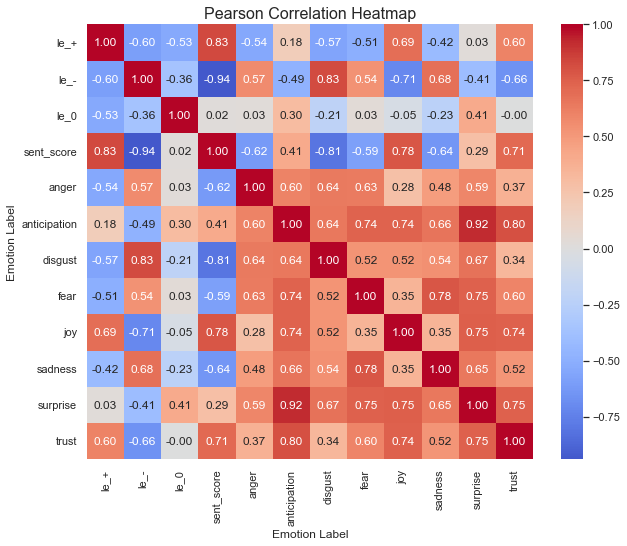

In [54]:
#Define columns for pearson correlation plot
cols = classes + emotions

#Calculate Pearson correlation coefficients
correlation_matrix = df_final_dim[cols].corr(method='pearson')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Pearson Correlation Heatmap", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()